In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

In [2]:
def feature_selection(dataframe,var_type):
    if var_type=="numerical":
        
        num_cols=dataframe.select_dtypes(include=['float64','int64']).columns
        num_cols=list(num_cols)
        return num_cols
    
    elif var_type=="categorical":
        cat_cols=dataframe.select_dtypes(include=['object','string']).columns
        cat_cols=list(cat_cols)
        return cat_cols
        
        

In [3]:
def plotting_features(dataframe,features_list):
    fig=plt.figure(figsize=(10,15))
    for i, var in enumerate(features_list):
        ax=plt.subplot(len(features_list),2,i+1)
        sns.boxplot(y=dataframe[var],ax=ax)
        

In [4]:
def removing_outliers(dataframe):
    col_with_outliers=[]
    num_data=dataframe.select_dtypes(include=['float64','int64'])
    for column in num_data.columns:
        sorted(num_data[column])
        Q1,Q3=num_data[column].quantile([0.25,0.75])
        IQR=Q3-Q1
        low=Q1-(1.5*IQR)
        high=Q3+(1.5*IQR)
        col=sorted(num_data[column])
        if any(num>high for num in col) or any(num<low for num in col):
            col_with_outliers.append(column)
            
    if col_with_outliers:
        for column in col_with_outliers:
            sorted(dataframe[column])
            Q1,Q3=num_data[column].quantile([0.25,0.75])
            IQR=Q3-Q1
            low=Q1-(1.5*IQR)
            high=Q3+(1.5*IQR)
            dataframe[column]=np.where(dataframe[column]>high,high,dataframe[column])
            dataframe[column]=np.where(dataframe[column]<low,low,dataframe[column])
            


In [5]:
def encoding(cols):
    outcome=cols
    
    
    if outcome=='Yes' or outcome=='Male':
        return '1'
    else:
        return '0'


In [6]:
def plot_results(model, param, name):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('mean_test_score')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

In [7]:
def grid_search(param,estimators,X_train, y_train,X_test,y_test):
    n=len(param)
    names=[]
    scores=[]
    for i in range(0,n):
        importances=[]
        grid_search = GridSearchCV(estimator=estimators[i], 
        param_grid=param[i],cv=KFold(n_splits=5, shuffle=True, random_state=1))
        grid_search.fit(X_train, y_train)
        names.append(str(estimators[i]).split("(")[0])
        scores.append(grid_search.cv_results_['mean_test_score'])
        print(f'Best parameters for {str(estimators[i]).split("(")[0]} are {grid_search.best_params_}')
        importances=grid_search.best_estimator_.feature_importances_
        feature_list=X_train.columns
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
        feature_importances = sorted(feature_importances,key= lambda x: x[1], reverse = True)
        predictions=grid_search.predict(X_test)
        errors = abs(predictions - y_test)
        mape = 100 * (errors / y_test)
        accuracy = 100 - np.mean(mape)
        print('Accuracy:', round(accuracy, 2), '%.')
        print('Feature importances:\n')
        [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
        print('\n')
    plt.figure(figsize=(10, 4))    
    plt.boxplot(scores, labels=names, showmeans=True, )
    plt.title('Boxplot of mean test scores')
    
    '''Tutaj dodac jeszcze np best parameters zeby drukowalo dla danego modelu'''
    
    grid_search.best_estimator_.feature_importances_

In [8]:
path=r'C:\Users\mkepa\Downloads\Sleep_Efficiency.csv'

In [9]:
data=pd.read_csv(path)

In [10]:
data.head()

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


In [11]:
data.isnull().sum()

ID                         0
Age                        0
Gender                     0
Bedtime                    0
Wakeup time                0
Sleep duration             0
Sleep efficiency           0
REM sleep percentage       0
Deep sleep percentage      0
Light sleep percentage     0
Awakenings                20
Caffeine consumption      25
Alcohol consumption       14
Smoking status             0
Exercise frequency         6
dtype: int64

In [12]:
data=data.fillna(method="ffill")

In [13]:
numerical_columns=feature_selection(data,"numerical")

In [14]:
numerical_columns=numerical_columns[1:]

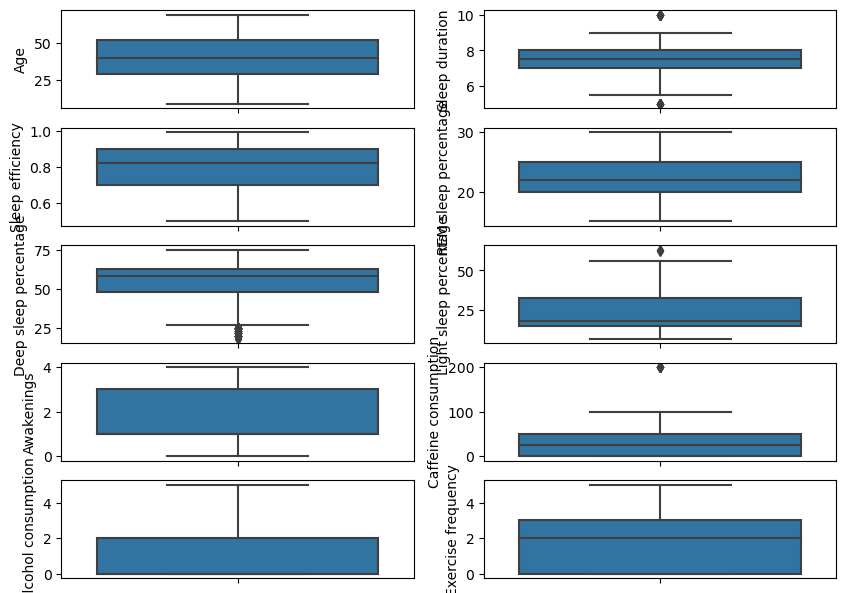

In [15]:
plotting_features(data,numerical_columns)

In [16]:
removing_outliers(data)  

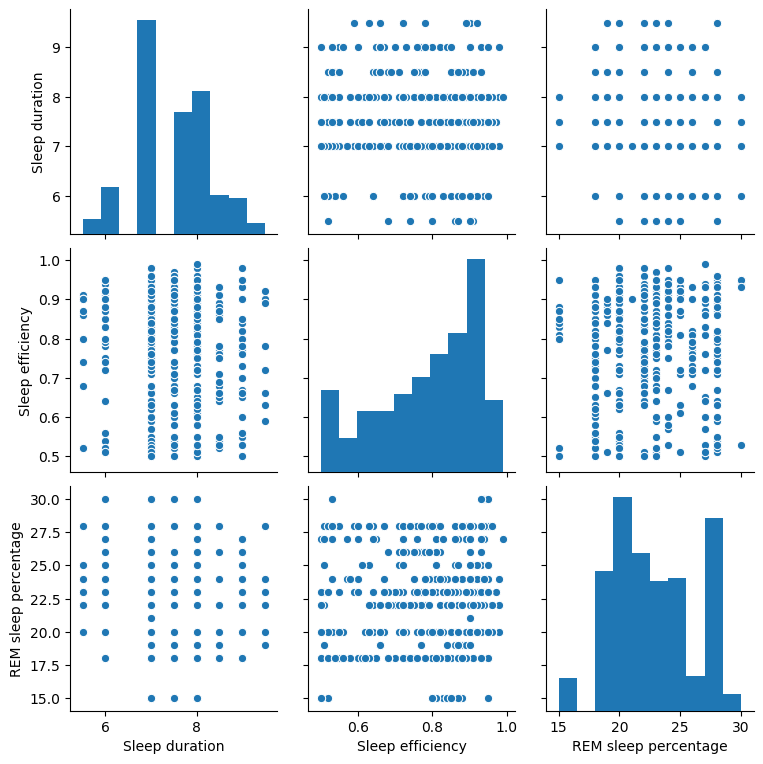

In [15]:
sns.pairplot(data[numerical_columns[1:4]])

In [17]:
data.drop(['Bedtime','Wakeup time'],inplace=True,axis=1)

In [18]:
data['Smoking status']=data['Smoking status'].apply(encoding)

In [19]:
data['Gender']=data['Gender'].apply(encoding)

In [20]:
y=data['Sleep efficiency']

In [21]:
X=data.drop(['ID','Sleep efficiency'],axis=1)

In [22]:
X[['Gender','Smoking status']]=X[['Gender','Smoking status']].astype(int)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [26]:
param_grid = [{'max_depth': [5,10,20],'max_features' : [4,8,11],'n_estimators': [20,50]},{'max_depth': [5,10,20],'learning_rate': [0.01, 0.1, 0.3],'max_features' : [4,8,11],'n_estimators': [20,50]},{
    'max_depth': [3, 4, 5],
    'n_estimators': [20,50,100],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'alpha': [0, 0.1, 1],
    'lambda': [1, 2, 10],
    'learning_rate': [0.01, 0.1, 0.3]
}]
estimators=[RandomForestRegressor(random_state=0),GradientBoostingRegressor(random_state=42),xgb.XGBRegressor(eval_metric='rmse')]

Best parameters for RandomForestRegressor are {'max_depth': 5, 'max_features': 8, 'n_estimators': 50}
Accuracy: 95.25 %.
Feature importances:

Variable: Light sleep percentage Importance: 0.43
Variable: Deep sleep percentage Importance: 0.35
Variable: Awakenings           Importance: 0.12
Variable: Age                  Importance: 0.03
Variable: Alcohol consumption  Importance: 0.02
Variable: Smoking status       Importance: 0.02
Variable: Sleep duration       Importance: 0.01
Variable: REM sleep percentage Importance: 0.01
Variable: Exercise frequency   Importance: 0.01
Variable: Gender               Importance: 0.0
Variable: Caffeine consumption Importance: 0.0


Best parameters for GradientBoostingRegressor are {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 8, 'n_estimators': 20}
Accuracy: 95.08 %.
Feature importances:

Variable: Light sleep percentage Importance: 0.47
Variable: Deep sleep percentage Importance: 0.28
Variable: Awakenings           Importance: 0.12
Variable: 

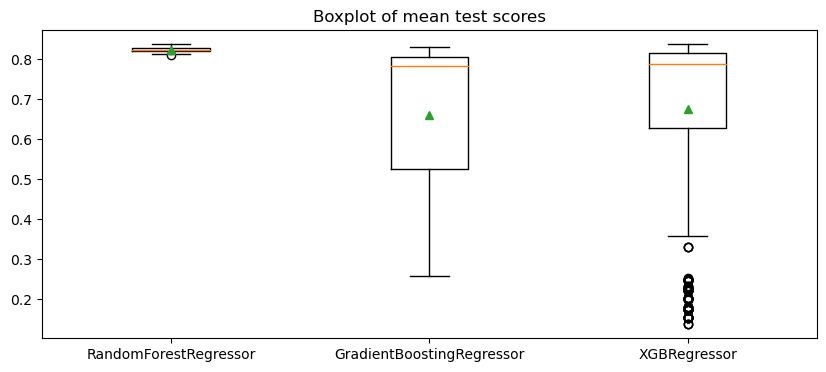

In [27]:
grid_search(param_grid,estimators,X_train, y_train,X_test,y_test)

In [63]:
tree_grid = {'n_estimators': np.arange(0,330,30)}
tree_grid_search=GridSearchCV(estimator=estimators[0], 
param_grid=tree_grid,cv=KFold(n_splits=5, shuffle=True, random_state=1), verbose=2)

In [ ]:
tree_grid_search.fit(X_train, y_train)

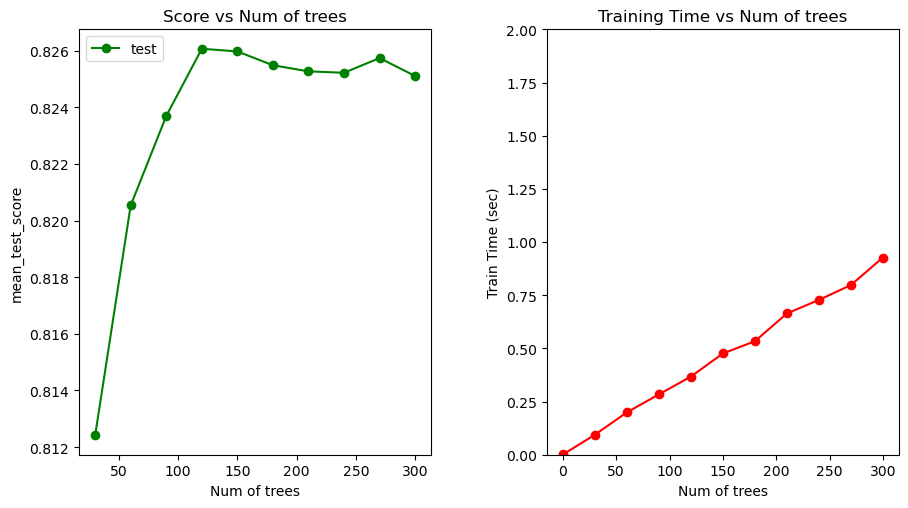

In [65]:
plot_results(tree_grid_search,param='n_estimators',name='Num of trees')

In [48]:
feature_grid = {'max_features': list(range(1, X_train.shape[1] + 1))}
feature_grid_search=GridSearchCV(estimator=estimators[0], 
param_grid=feature_grid,cv=KFold(n_splits=5, shuffle=True, random_state=1), verbose=2)

In [ ]:
feature_grid_search.fit(X_train, y_train)

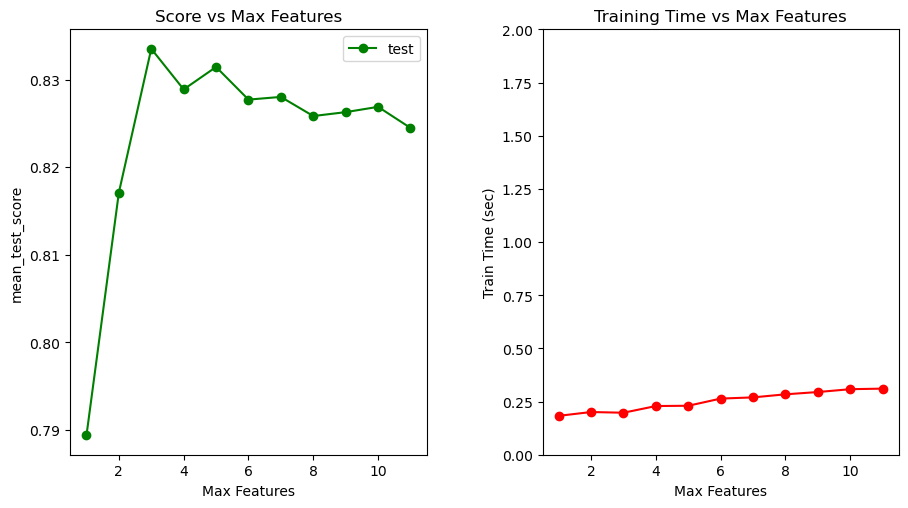

In [50]:
plot_results(feature_grid_search, param='max_features', name = 'Max Features')